## Language analysis using Python and Spacy

We will use the Python module Spacy to analize the Fraser Radio archives. On the way we will learn a couple of other tricks to make our lives easier.


```
wget https://archives.unimelb.edu.au/__data/assets/text_file/0006/1717746/UMA_Fraser_Radio_Talks.zip
pip3 install spacy
python -m spacy download en_core_web_sm
```

That gets us ready to do the linguistic work.

But before that, we need to read the data in and clean it up.

In [3]:
# Can we see the files? Yes - here are the titles. 
import os
files = os.listdir('UMA_Fraser_Radio_Talks')
print(files[:3])

['UDS2013680-373-full.txt', 'UDS2013680-240-full.txt', 'UDS2013680-720-full.txt']


These files are txt files - the file type that traditionally contains text. Great, let's look inside them.

In [4]:
# Can we read the files as text? Yes... No.
f = open(os.path.join('UMA_Fraser_Radio_Talks', files[0]), "r")
text = f.read()
print(text)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x84 in position 2857: invalid start byte

### UnicodeDecode Errors - character sets, unicode and automation

UnicodeDecode errors will be frequent in Python version 3 - they have changed how they represent human language within the Python language. While it's annoying - and slightly more work - the solution we implement below is relatively quick and solves the problem *regardless of the language of the documents we are researching*.


In [5]:
# Can we read the files as binary text files? Yes!
f = open(os.path.join('UMA_Fraser_Radio_Talks', files[0]), 'rb')
text = f.read()
print(text)

b'<!--start metadata-->\r\nTitle: Closure of the customs inwards and outwards shipping register for Portland\r\nDescription: radio talk\r\nDate: c1957\r\nCollection: John Malcolm Fraser, 2007.0023\r\nCollection URI: http://gallery.its.unimelb.edu.au/imu/imu.php?request=load&irn=115190&ecatalogue=on&view=details\r\nFormat: Uncorrected OCR text\r\n<!--end metadata-->\r\n\r\n\r\ns.\r\n                                NEW ITEM.\r\n\r\n\r\n                  A most unusual ceremony took place at Parliament \r\n      House, Canberra, on Thursday, 14th November, 1957, when the \r\n      Einister of State for Customs and Excise, Senator, the Hon. \r\n      Denham Henty closed the Customs Inward6and OutwardsShipping \r\n      Register, for theport of Portland, Victoria, just 100 years\r\n      after the first entry was made in it.\r\n                  These Registers record shipping movements into \r\n      and out of the ports of the Commonwealth and show such things \r\n       as tonnages, numb

OK, that looks better. What was that **b** we added to the open path? That told python to open the file to (r)ead - but to read the file as a byte stream instead of as text<sup>1</sup>. That's handy, but why and is it useful? 

<sup>1</sup> with the default ASCII encoding. This is important later.

Well, we can now read the file - and we can see the section near the bottom of the file that caused the issue. That second box shows another example - although in this case it's valid ASCII.


![Hex Chars](imgs/non-text-characters_small.png "Hex Chars")


What we are seeing here is a data quality issue. This is very common, especially with text that has been scanned from PDFs. The image to text transfer will make a best guess, and in this case it's guessed an unusual character. If you take a look at the [original pdf](https://digitised-collections.unimelb.edu.au/bitstream/handle/11343/40335/312821_2007-0023-0372.pdf), you can see that this is because Mr Cain had made hand written notes on the bottom of his talk. 

The character combination **\x** is a restriction within [ASCII](https://en.wikipedia.org/wiki/ASCII) text files - it is a leading indicator used to encode characters as bytes. For instance \x20 is the space character, \x3a is the colon character (:) and \x41 is capital A. 

We wont go into character encoding now, but we will show into how to solve the problem. The problem starts with **\x84** being an invalid ASCII code - **\x7F** (the "Delete" character) is as high as ASCII goes. 

Why do we want to solve this - why not just import the files as "bytestreams"? The primary reason is that text manipulation in python is powerful and easy to use - but it only works on text, not bytestreams. 

Thankfully, those that came before us have solved the problem of guessing the encoding and have written a Python modue called Chardet ("character detect") to solve it. How did I know to use this software? I did a search for "python determine character set".

### Character Set Detection

Let's install chardet and use that to get an idea for the probable character encoding. This code is copy and pasted from [the Chardet documentation](https://chardet.readthedocs.io/en/latest/usage.html#example-detecting-encodings-of-multiple-files) and slightly altered.


In [6]:
import chardet
from chardet.universaldetector import UniversalDetector

detector = UniversalDetector()

for f in files[20:25]:
    filename=os.path.join('UMA_Fraser_Radio_Talks',f)
    detector.reset()
    for line in open(filename, 'rb'):
        detector.feed(line)
        if detector.done: break
    detector.close()
    print(f, ": ", detector.result)

UDS2013680-546-full.txt :  {'encoding': 'Windows-1252', 'confidence': 0.73, 'language': ''}
UDS2013680-297-full.txt :  {'encoding': 'Windows-1252', 'confidence': 0.73, 'language': ''}
UDS2013680-639-full.txt :  {'encoding': 'ascii', 'confidence': 1.0, 'language': ''}
UDS2013680-206-full.txt :  {'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}
UDS2013680-583-full.txt :  {'encoding': 'Windows-1252', 'confidence': 0.73, 'language': ''}


Ideally all text files for what are known English Language texts would just be in English, but as you can see the data isn't as clean as we would like. In fact, there are at least three detected character encodings - **Windows-1252**, **ASCII** and **ISO-8859-1**. 

We will need to deal with this on a file by file basis - but thankfully we don't actually need to know what each of those encodings represents. 

The reality is that - like with our first file - the problem is dirty data problem. A single misreaded character by the Optical Character Recognition software and everything is a mess.

Let's turn the above into a function that just returns the encoding so we can use it repeatedly.

In [7]:
def get_charset(filename):

    import chardet
    from chardet.universaldetector import UniversalDetector

    detector = UniversalDetector()
    detector.reset()
    for line in open(filename, 'rb'):
        detector.feed(line)
        if detector.done: break
    detector.close()

    return detector.result['encoding']

In [8]:
filename = os.path.join('UMA_Fraser_Radio_Talks', files[0])
encoding = get_charset(filename)
f = open(filename, 'r', encoding=encoding)
text = f.read()
print(text)

<!--start metadata-->
Title: Closure of the customs inwards and outwards shipping register for Portland
Description: radio talk
Date: c1957
Collection: John Malcolm Fraser, 2007.0023
Collection URI: http://gallery.its.unimelb.edu.au/imu/imu.php?request=load&irn=115190&ecatalogue=on&view=details
Format: Uncorrected OCR text
<!--end metadata-->


s.
                                NEW ITEM.


                  A most unusual ceremony took place at Parliament 
      House, Canberra, on Thursday, 14th November, 1957, when the 
      Einister of State for Customs and Excise, Senator, the Hon. 
      Denham Henty closed the Customs Inward6and OutwardsShipping 
      Register, for theport of Portland, Victoria, just 100 years
      after the first entry was made in it.
                  These Registers record shipping movements into 
      and out of the ports of the Commonwealth and show such things 
       as tonnages, number of passengers and crew, and so on.
                  In this inst

### Meta Data

Now that looks much better. 

Let's keep cleaning it up. Looks like we can remove the metadata from the top. We could put it into a database or a dictionary for later use if we want. For the moment, let's just split it out.

In [9]:
data = text.split("<!--end metadata-->")
data[0]

'<!--start metadata-->\nTitle: Closure of the customs inwards and outwards shipping register for Portland\nDescription: radio talk\nDate: c1957\nCollection: John Malcolm Fraser, 2007.0023\nCollection URI: http://gallery.its.unimelb.edu.au/imu/imu.php?request=load&irn=115190&ecatalogue=on&view=details\nFormat: Uncorrected OCR text\n'

Ok. Let's see if we can't start making some sense of what we have.

In [10]:
# split into lines, add '*' to the start of each line
# \n is a newline character
for line in data[0].split('\n'):
    print('*', line)

* <!--start metadata-->
* Title: Closure of the customs inwards and outwards shipping register for Portland
* Description: radio talk
* Date: c1957
* Collection: John Malcolm Fraser, 2007.0023
* Collection URI: http://gallery.its.unimelb.edu.au/imu/imu.php?request=load&irn=115190&ecatalogue=on&view=details
* Format: Uncorrected OCR text
* 


In [11]:
# skip empty lines and any line that starts with '<'
for line in data[0].split('\n'):
    if not line:
        continue
    if line.startswith('<'):
        continue
    print('*', line)

* Title: Closure of the customs inwards and outwards shipping register for Portland
* Description: radio talk
* Date: c1957
* Collection: John Malcolm Fraser, 2007.0023
* Collection URI: http://gallery.its.unimelb.edu.au/imu/imu.php?request=load&irn=115190&ecatalogue=on&view=details
* Format: Uncorrected OCR text


In [12]:
# split the metadata items on ':' so that we can interrogate each one
for line in data[0].split('\n'):
    if not line:
        continue
    if line[0] == '<':
        continue
    element = line.split(':')
    print('*', element)


* ['Title', ' Closure of the customs inwards and outwards shipping register for Portland']
* ['Description', ' radio talk']
* ['Date', ' c1957']
* ['Collection', ' John Malcolm Fraser, 2007.0023']
* ['Collection URI', ' http', '//gallery.its.unimelb.edu.au/imu/imu.php?request=load&irn=115190&ecatalogue=on&view=details']
* ['Format', ' Uncorrected OCR text']


In [13]:
# actually, only split on the first colon
for line in data[0].split('\n'):
    if not line:
        continue
    if line[0] == '<':
        continue
    element = line.split(':', 1)
    print('*', element)

* ['Title', ' Closure of the customs inwards and outwards shipping register for Portland']
* ['Description', ' radio talk']
* ['Date', ' c1957']
* ['Collection', ' John Malcolm Fraser, 2007.0023']
* ['Collection URI', ' http://gallery.its.unimelb.edu.au/imu/imu.php?request=load&irn=115190&ecatalogue=on&view=details']
* ['Format', ' Uncorrected OCR text']


Good. Let's put it into a dictionary so we can use it later. 

The point of dictionaries is to store a key (the word) and a value (the count). When you ask for the key, you get its value.

Notice that you use curly braces for dictionaries, but square brackets for lists.

Dictionaries are a great way to work with the metadata in our corpus. Let's build a dictionary called metadata:

Your first line will look like this:

  metadata = {}

In [14]:
metadata = {}
for line in data[0].split('\n'):
    if not line:
        continue
    if line[0] == '<':
        continue
    element = line.split(':', 1)
    metadata[element[0]] = element[-1]
print(metadata)

{'Title': ' Closure of the customs inwards and outwards shipping register for Portland', 'Description': ' radio talk', 'Date': ' c1957', 'Collection': ' John Malcolm Fraser, 2007.0023', 'Collection URI': ' http://gallery.its.unimelb.edu.au/imu/imu.php?request=load&irn=115190&ecatalogue=on&view=details', 'Format': ' Uncorrected OCR text'}


In [15]:
print(metadata['Date'])

 c1957


Let's turn that into a function as well - we will be coming back to it for each file.

In [16]:
def parse_metadata(text):
    metadata = {}
    for line in text.split('\n'):
        if not line:
            continue
        if line[0] == '<':
            continue
        element = line.split(':', 1)
        metadata[element[0]] = element[-1].strip(' ')
    return metadata

In [17]:
md = parse_metadata(data[0])
print(md)

{'Title': 'Closure of the customs inwards and outwards shipping register for Portland', 'Description': 'radio talk', 'Date': 'c1957', 'Collection': 'John Malcolm Fraser, 2007.0023', 'Collection URI': 'http://gallery.its.unimelb.edu.au/imu/imu.php?request=load&irn=115190&ecatalogue=on&view=details', 'Format': 'Uncorrected OCR text'}


### Metadata collection
Now that we have all the tools we need to collect each file's metadata, let's do put it into a data structure so we can do some analysis.

In [18]:
fraser_talks_metadata = {}

for file in os.listdir('UMA_Fraser_Radio_Talks'):
    # If anything goes wrong, we will know which files to look at.
    try:
        filename = os.path.join('UMA_Fraser_Radio_Talks', file)
        encoding = get_charset(filename)
        text = open(filename, 'r', encoding=encoding).read()
    except:
        print("file is", filename, " and it's chardet data is", get_charset(filename))
        continue
    
    
    #split text of file on 'end metadata'
    data = text.split("<!--end metadata-->")
    
    #parse metadata using previously defined function "parse_metadata"
    metadata = parse_metadata(data[0])
    talk_data = data[1]
      
    fraser_talks_metadata[file]={'metadata':metadata, 'talk_data':talk_data}
    


file is UMA_Fraser_Radio_Talks/UDS2013680-152-full.txt  and it's chardet data is None


## Every error will be fixed. 

Something is wrong with that file. We will need to open it up to take a look. When we [open the file in jupyter notebook](UMA_Fraser_Radio_Talks/UDS2013680-152-full.txt) we can see at the very bottom two odd looking characters.

![](imgs/weird_characters.png "asda") 
             
What we have found is a document with conflicted information about what character encoding it is - those two characters are usual (on inspection, they are 0xC (the Form Feed character) and 0xDC (unknown). 

Since it's only one file and the process for discovery is nerdy and tedious, we will re-run the above with what professionals call [a *hack*](workingprocess.ipynb). I will put in a one time exception for this single file. You will not pass a PhD with hacks.

In [19]:
fraser_talks_metadata = {}

for file in os.listdir('UMA_Fraser_Radio_Talks'):
    # If anything goes wrong, we will know which files to look at.
    try:
        filename = os.path.join('UMA_Fraser_Radio_Talks', file)
        encoding = get_charset(filename)
        text = open(filename, 'r', encoding=encoding).read()
    except:
        # Special case: open the file in as binary, only read the first 2650 bytes
        # once they are read, decode the binary as ascii
        file_handle = open(filename, 'rb')
        text = file_handle.read(2650).decode('ascii')
            
    #split text of file on 'end metadata'
    data = text.split("<!--end metadata-->")
    
    #parse metadata using previously defined function "parse_metadata"
    metadata = parse_metadata(data[0])
    talk_data = data[1]
      
    fraser_talks_metadata[file]={'metadata':metadata, 'talk_data':talk_data}

fraser_talks_metadata['UDS2013680-152-full.txt']['metadata']

{'Title': 'Portland wool sales\r',
 'Description': 'press statement\r',
 'Date': '26/04/1964\r',
 'Collection': 'John Malcolm Fraser, 2007.0023\r',
 'Collection URI': 'http://gallery.its.unimelb.edu.au/imu/imu.php?request=load&irn=115190&ecatalogue=on&view=details\r',
 'Format': 'Uncorrected OCR text\r'}

In [20]:
from collections import Counter

fraser_talks_metadata.keys()

dates = []

for file_id in fraser_talks_metadata:
    date = fraser_talks_metadata[file_id]['metadata']['Date']
    if date.startswith('c'):
    # date format cyyyy
        year = date[1:]
    elif len(date) == 10:
    # date format dd/mm/yyyy
        year = date[6:]
    elif len(date) == 9:
    # date format d/mm/yyyy
        year = date[5:]
    if len(year) == 5:
    # pesky space in 1969
        year = year.lstrip()
    dates.append(year)
        
Counter(dates)

Counter({'1957': 37,
         '1967': 92,
         '1981': 23,
         '1964': 44,
         '1970': 36,
         '1965': 39,
         '1961': 41,
         '1959': 41,
         '1963': 48,
         '1968': 26,
         '1958': 33,
         '1954': 24,
         '1973': 33,
         '1971': 27,
         '1974': 19,
         '1956': 16,
         '1982': 23,
         '1960': 41,
         '1972': 42,
         '1975': 40,
         '1969': 15,
         '1962': 31,
         '1966': 3})

Can we order those years? Probably. But at the moment they are strings, but we will want to order them as integers.

In [50]:
from collections import OrderedDict

data_summary = OrderedDict(sorted(Counter(dates).items(), key=lambda t: t))
data_summary


OrderedDict([('1954', 24),
             ('1956', 16),
             ('1957', 37),
             ('1958', 33),
             ('1959', 41),
             ('1960', 41),
             ('1961', 41),
             ('1962', 31),
             ('1963', 48),
             ('1964', 44),
             ('1965', 39),
             ('1966', 3),
             ('1967', 92),
             ('1968', 26),
             ('1969', 15),
             ('1970', 36),
             ('1971', 27),
             ('1972', 42),
             ('1973', 33),
             ('1974', 19),
             ('1975', 40),
             ('1981', 23),
             ('1982', 23)])

In [ ]:
### TODO describe splicing arrays and strings

In [ ]:
#### TODO plot that distribution

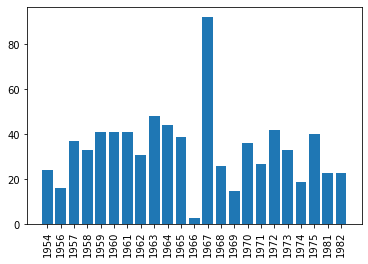

In [51]:
import matplotlib.pyplot as plt

#data_summary = Counter(dates)

# we make a bar graph, the y axis will be the values in the data_summary
plt.bar(range(len(data_summary)), list(data_summary.values()),align='center')

# we add in the x axis details - and turn the years around so they fit
plt.xticks(range(len(data_summary)), list(data_summary.keys()),rotation=90)

plt.show()

Ok. That looks great. Right away we can see that something momentous is happening in 1966 and 1967 - the lowest and highest number of talks respectively. If we look at his Wikipedia page, we can see that '66 is the year that he becomes a Government minister for the first time - and it's the Ministry for the Army as we enter the Vietnam War. 

Those records will be interesting to look at more closely later.

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")